<a href="https://colab.research.google.com/github/mitkrieg/citibike-timeseries/blob/main/fbprophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from fbprophet import Prophet
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Flatiron/Capstone/data

Mounted at /gdrive
/gdrive/MyDrive/Flatiron/Capstone/data


In [4]:
%cd ..
% ls

/gdrive/MyDrive/Flatiron/Capstone
cleaning.py  fbprophet_model.ipynb  __pycache__/   trips.pickle
data/        historical.pickle      starts.pickle
ends.pickle  live.pickle            station.py


In [5]:
df = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/train_ts.pickle','rb'))
df_test = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/test_ts.pickle','rb'))

In [6]:
df

,ds,y
0,2018-06-17 00:00:00,5.0
1,2018-06-17 01:00:00,3.5
2,2018-06-17 02:00:00,3.0
3,2018-06-17 03:00:00,2.0
4,2018-06-17 04:00:00,2.0
...,...,...
331,2018-06-30 19:00:00,14.0
332,2018-06-30 20:00:00,3.0
333,2018-06-30 21:00:00,9.5
334,2018-06-30 22:00:00,10.0


In [7]:
df_test

,ds,y
0,2018-06-18 00:00:00,2.5
1,2018-06-18 01:00:00,1.0
2,2018-06-18 02:00:00,12.0
3,2018-06-18 03:00:00,11.5
4,2018-06-18 04:00:00,11.0
...,...,...
643,2018-07-14 19:00:00,1.0
644,2018-07-14 20:00:00,3.0
645,2018-07-14 21:00:00,4.5
646,2018-07-14 22:00:00,2.5


In [8]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods = 14*24, freq='H')
future

,ds
0,2018-06-17 00:00:00
1,2018-06-17 01:00:00
2,2018-06-17 02:00:00
3,2018-06-17 03:00:00
4,2018-06-17 04:00:00
...,...
667,2018-07-14 19:00:00
668,2018-07-14 20:00:00
669,2018-07-14 21:00:00
670,2018-07-14 22:00:00


In [10]:
forcast = m.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-17 00:00:00,9.404598,3.725520,15.046142
1,2018-06-17 01:00:00,9.153126,2.953549,15.013052
2,2018-06-17 02:00:00,9.186885,2.966076,15.423599
3,2018-06-17 03:00:00,9.604113,3.460299,15.910060
4,2018-06-17 04:00:00,9.981806,3.812999,16.294489
...,...,...,...,...
667,2018-07-14 19:00:00,22.168310,16.535472,28.410375
668,2018-07-14 20:00:00,23.757203,17.237305,29.418154
669,2018-07-14 21:00:00,24.453819,18.525026,30.479105
670,2018-07-14 22:00:00,24.632130,18.372374,30.789234


In [11]:
train_ts = df.set_index('ds')
forcast_ts = forcast.set_index('ds')
test_ts = df_test.set_index('ds')

In [12]:
forcast_ts.yhat_upper.sort_values()

ds
2018-06-17 10:00:00     1.897366
2018-06-17 11:00:00     2.135118
2018-06-17 13:00:00     2.856679
2018-06-17 12:00:00     2.892364
2018-06-17 09:00:00     3.030991
                         ...    
2018-07-12 00:00:00    35.236594
2018-07-12 21:00:00    35.340586
2018-07-12 05:00:00    35.870793
2018-07-12 03:00:00    35.912619
2018-07-12 04:00:00    36.374567
Name: yhat_upper, Length: 672, dtype: float64

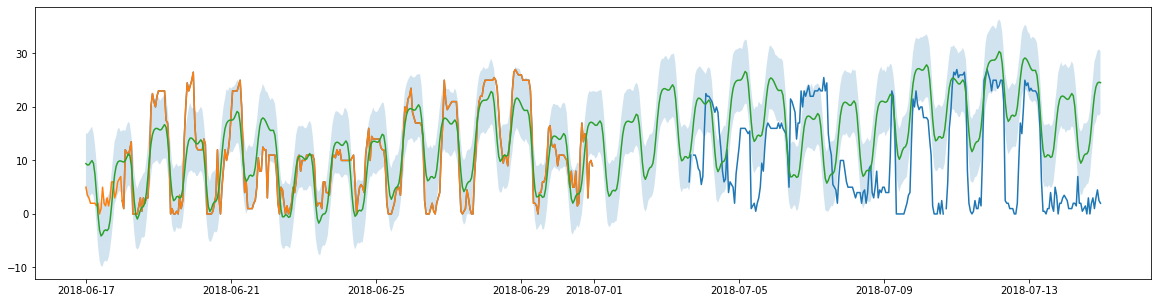

In [13]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.plot(test_ts,label='test')
ax.plot(train_ts,label='train')
ax.plot(forcast_ts.yhat,label='forcast')
ax.fill_between(forcast_ts.index,forcast_ts.yhat_lower,forcast_ts.yhat_upper,alpha=0.2)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
train_rmse = mean_squared_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'],
                   squared=False)

test_rmse = mean_squared_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
                               squared=False)

train_mae = mean_absolute_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'])

test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 4.642565388704062
Train MAE:  3.8067613835242335

Test RMSE: 11.15830362713161
Test MAE:  9.654498200331382


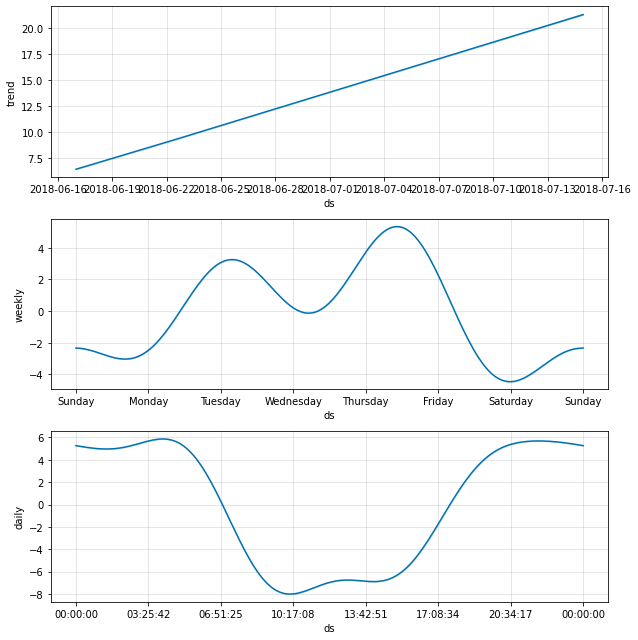

In [16]:
m.plot_components(forcast);

In [17]:
from fbprophet.diagnostics import performance_metrics, cross_validation
from station import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [18]:
year_2018 = pickle.load(open('historical.pickle','rb'))

In [25]:
search_station_id('Amsterdam')

,station_name,station_id
371,Amsterdam Ave & W 73 St,3167
374,Amsterdam Ave & W 82 St,3171
377,W 70 St & Amsterdam Ave,3175
441,W 87 St & Amsterdam Ave,3285
445,W 90 St & Amsterdam Ave,3289
505,Amsterdam Ave & W 66 St,3356
506,W 106 St & Amsterdam Ave,3357
638,W 110 St & Amsterdam Ave,3538
639,W 116 St & Amsterdam Ave,3539
641,Amsterdam Ave & W 125 St,3541


In [34]:
station_3176 = year_2018.loc[3167]

In [35]:
availbikes = station_3176.reset_index()[['date_time','avail_bikes']]
availbikes.rename(columns={'date_time':'ds','avail_bikes':'y'}, inplace=True)

In [36]:
year_model = Prophet(yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=True)
year_model.fit(availbikes)

In [37]:
future = year_model.make_future_dataframe(periods = 24*119,freq='H')
forcast = year_model.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 00:26:00,29.448397,17.939264,41.841834
1,2018-01-01 00:59:00,29.444375,16.837139,41.119898
2,2018-01-01 01:32:00,29.526508,17.712821,42.001558
3,2018-01-01 02:04:00,29.658655,18.372261,41.920162
4,2018-01-01 02:38:00,29.842953,17.598390,41.747193
...,...,...,...,...
13973,2019-04-29 19:30:00,29.486091,9.263080,50.096823
13974,2019-04-29 20:30:00,30.580743,11.483477,48.156919
13975,2019-04-29 21:30:00,30.239292,9.394189,50.987473
13976,2019-04-29 22:30:00,29.355842,9.201277,48.398577


In [38]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

In [39]:
true_year_ts.head()

,y
ds,
2018-01-01 00:26:00,34
2018-01-01 00:59:00,35
2018-01-01 01:32:00,35
2018-01-01 02:04:00,35
2018-01-01 02:38:00,34


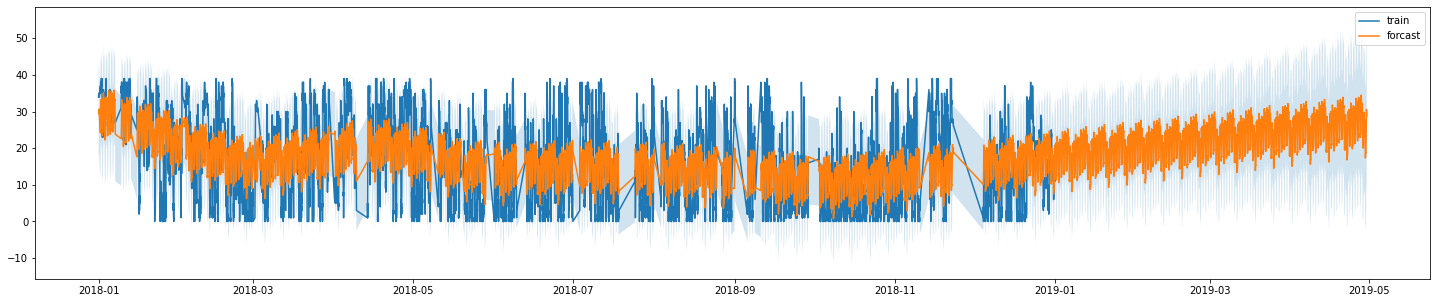

In [40]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
ax.legend()

In [42]:
ax.set_xlim(left='2018-06-01',right='2018-06-30')

ConversionError: ignored

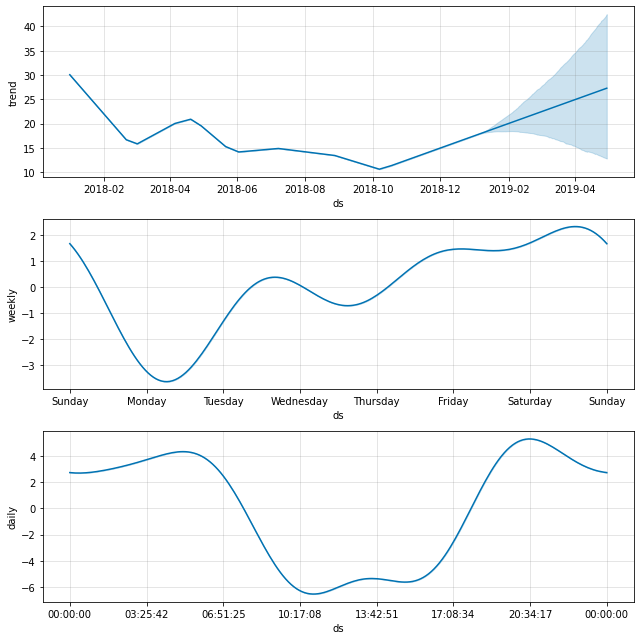

In [41]:
year_model.plot_components(forcast);